In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from IPython.display import display

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# TODO: Loading the dataset
data_path = os.path.join("../data", "train.csv")
data = pd.read_csv(data_path)

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
# TODO: Visualize the data statistical overview
print("Statistical Overview:")
display(data.describe())

print("\nDataset Information:")
data.info()

print("\nMissing Values:")
display(data.isna().sum())

Statistical Overview:


,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null  

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [4]:
# TODO: Sample a few rows from the dataset, random seed for reproducability
data.sample(10, random_state=10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
4495,4496,CA-2018-112753,18/06/2018,23/06/2018,Standard Class,CC-12670,Craig Carreira,Consumer,United States,Los Angeles,California,90032.0,West,FUR-BO-10004015,Furniture,Bookcases,"Bush Andora Bookcase, Maple/Graphite Gray Finish",917.9235
192,193,CA-2016-102281,12/10/2016,14/10/2016,First Class,MP-17470,Mark Packer,Home Office,United States,New York City,New York,10035.0,East,FUR-BO-10002545,Furniture,Bookcases,"Atlantic Metals Mobile 3-Shelf Bookcases, Cust...",626.3520
9075,9076,US-2016-136259,05/11/2016,08/11/2016,First Class,CB-12415,Christy Brittain,Consumer,United States,Lakewood,Ohio,44107.0,East,OFF-BI-10000773,Office Supplies,Binders,Insertable Tab Post Binder Dividers,7.2180
1523,1524,CA-2016-144806,06/12/2016,11/12/2016,Standard Class,GH-14425,Gary Hwang,Consumer,United States,Tucson,Arizona,85705.0,West,OFF-PA-10003039,Office Supplies,Paper,Xerox 1960,198.2720
2145,2146,US-2017-152051,25/06/2017,29/06/2017,Standard Class,TS-21160,Theresa Swint,Corporate,United States,York,Pennsylvania,17403.0,East,FUR-CH-10002965,Furniture,Chairs,Global Leather Highback Executive Chair with P...,422.0580
5160,5161,CA-2016-156146,26/10/2016,30/10/2016,Second Class,AG-10495,Andrew Gjertsen,Corporate,United States,Peoria,Arizona,85345.0,West,TEC-PH-10001527,Technology,Phones,Plantronics MX500i Earset,68.7200
1645,1646,CA-2016-111829,19/03/2016,20/03/2016,First Class,FH-14365,Fred Hopkins,Corporate,United States,Seattle,Washington,98115.0,West,OFF-PA-10004359,Office Supplies,Paper,Multicolor Computer Printout Paper,209.7000
8077,8078,CA-2016-106187,23/06/2016,29/06/2016,Standard Class,RF-19345,Randy Ferguson,Corporate,United States,East Point,Georgia,30344.0,South,OFF-BI-10004519,Office Supplies,Binders,GBC DocuBind P100 Manual Binding Machine,165.9800
8094,8095,CA-2018-133046,27/07/2018,01/08/2018,Second Class,DK-13375,Dennis Kane,Consumer,United States,Seattle,Washington,98115.0,West,OFF-PA-10003883,Office Supplies,Paper,"Message Book, Phone, Wirebound Standard Line M...",26.2000
5439,5440,CA-2017-167115,04/04/2017,09/04/2017,Standard Class,EH-14185,Evan Henry,Consumer,United States,New York City,New York,10035.0,East,OFF-BI-10004600,Office Supplies,Binders,Ibico Ibimaster 300 Manual Binding System,588.7840


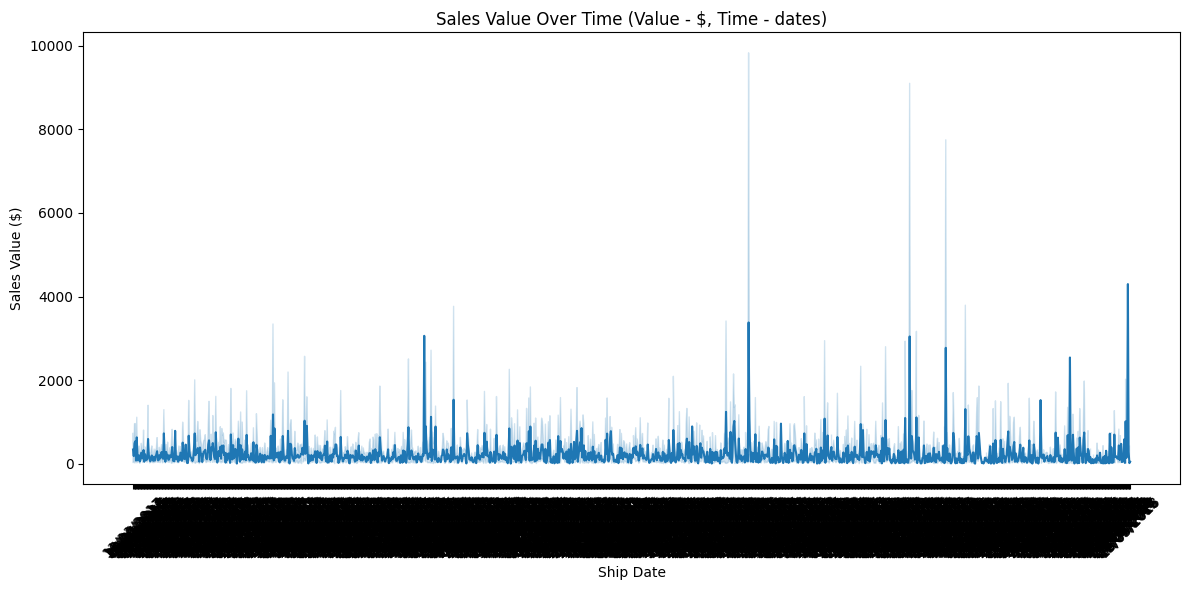

In [5]:
# TODO: Visualize the sales volume over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="Ship Date", y="Sales")
plt.title("Sales Value Over Time (Value - $, Time - dates)")
plt.xlabel("Ship Date")
plt.ylabel("Sales Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# # TODO: Smooth the sales value data to get a smoother curve
# data["smoothed_sales"] = data["Sales"].rolling(window=250, center=True).mean()
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data, x="Ship Date", y="smoothed_sales")
# plt.title("Sales Value Over Time (Value - $, Time - dates)")
# plt.xlabel("Ship Date")
# plt.ylabel("Sales Value ($)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

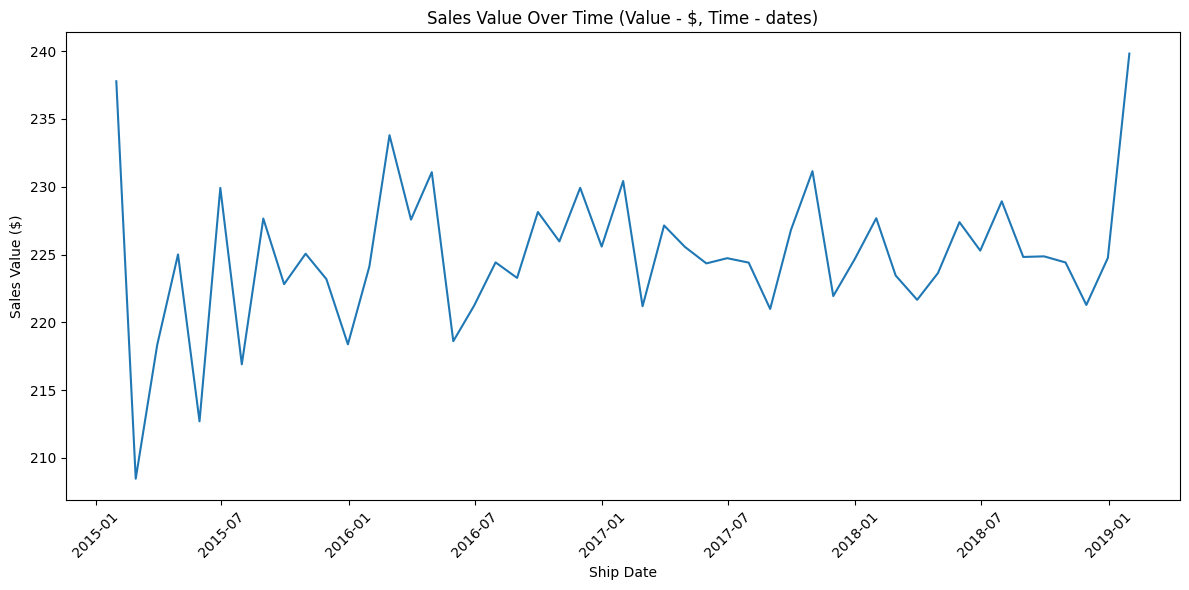

In [7]:
# TODO: Smooth using Exponential Moving Average(EMA)

data["Ship Date"] = pd.to_datetime(data["Ship Date"], dayfirst=True)
data.sort_index(ascending=False, inplace=True)
data.set_index('Ship Date', inplace=True)
data["ema_sales"] = data["Sales"].ewm(span=500, adjust=False).mean()
data_monthly = data[["Sales", "ema_sales"]].resample("M").mean()
data_monthly.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_monthly, x="Ship Date", y="ema_sales")
plt.title("Sales Value Over Time (Value - $, Time - dates)")
plt.xlabel("Ship Date")
plt.ylabel("Sales Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

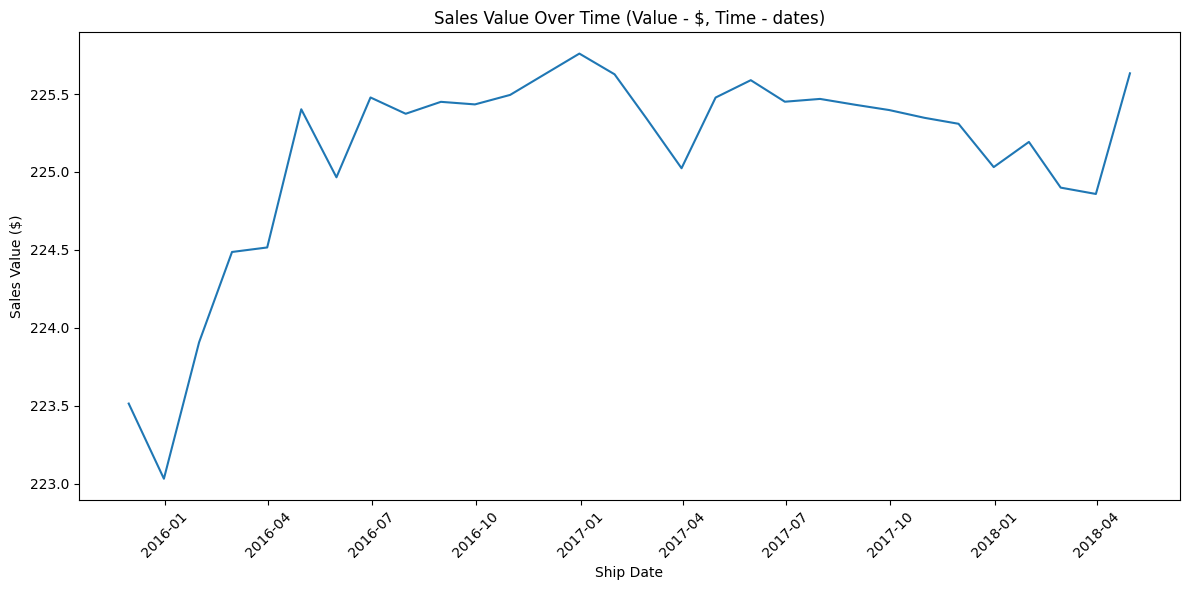

In [8]:
data_monthly["ema_sales_smoothed"] = data_monthly["ema_sales"].rolling(window=20, center=True).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_monthly, x="Ship Date", y="ema_sales_smoothed")
plt.title("Sales Value Over Time (Value - $, Time - dates)")
plt.xlabel("Ship Date")
plt.ylabel("Sales Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
data.head()

,Row ID,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,ema_sales
Ship Date,,,,,,,,,,,,,,,,,,
2016-01-17,9800,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-AC-10000487,Technology,Accessories,SanDisk Cruzer 4 GB USB Flash Drive,10.384,10.384000
2016-01-17,9799,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.376,10.447840
2016-01-17,9798,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.188,11.345007
2016-01-17,9797,CA-2016-128608,12/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.368,11.341106
2017-05-28,9796,CA-2017-125920,21/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.798,11.310994


In [10]:
data.describe()

,Row ID,Postal Code,Sales,ema_sales
count,9800.000000,9789.000000,9800.000000,9800.000000
mean,4900.500000,55273.322403,230.769059,224.678771
std,2829.160653,32041.223413,626.651875,36.319118
min,1.000000,1040.000000,0.444000,10.384000
25%,2450.750000,23223.000000,17.248000,206.206693
50%,4900.500000,58103.000000,54.490000,222.661276
75%,7350.250000,90008.000000,210.605000,242.247275
max,9800.000000,99301.000000,22638.480000,346.426288
